In [1]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
#from torch.optim.lr_scheduler import _LRScheduler

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import models
from torchsummary import summary
import torch.nn.functional as F


/home/MMI24limbyungwan/.conda/envs/byungwan_resn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# GPU 사용이 가능할 경우, GPU를 사용할 수 있게 함.'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

print(os.environ.get('CUDA_VISIBLE_DEVICES'))

cuda
2


In [3]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 클래스별 IoU를 계산하기 위한 함수
def calculate_iou_per_class(y_true, y_pred, class_id):
    intersection = np.sum((y_true == class_id) & (y_pred == class_id))
    union = np.sum((y_true == class_id) | (y_pred == class_id))
    iou = intersection / union if union > 0 else 0
    return iou

def calculate_ious(y_true, y_pred, class_num):
    ious = []
    for class_id in range(class_num):
        intersection = np.sum((y_true == class_id) & (y_pred == class_id))
        union = np.sum((y_true == class_id) | (y_pred == class_id))
        iou = intersection / union if union > 0 else 0
        ious.append(iou)
    return ious

def apply_fisheye_distortion(images, masks, label):
    # 이미지 크기 가져오기
    batch, channel, height, width = images.shape

    # 카메라 매트릭스 생성
    focal_length = width / 4
    center_x = width / 2
    center_y = height / 2
    camera_matrix = np.array([[focal_length, 0, center_x],
                              [0, focal_length, center_y],
                              [0, 0, 1]], dtype=np.float32)

    # 왜곡 계수 생성
    dist_coeffs = np.array([0, 0.02 * label, 0, 0], dtype=np.float32)

    # 왜곡 보정
    undistorted_images = []
    undistorted_masks = []

    for i in range(batch):
        image = images[i].permute(1, 2, 0).cpu().numpy()  # 텐서를 NumPy 배열로 변환
        mask = masks[i].cpu().numpy()
        undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)
        undistorted_mask = cv2.undistort(mask, camera_matrix, dist_coeffs)
        undistorted_mask = np.round(undistorted_mask).astype(np.uint8)
        undistorted_mask[undistorted_mask > 12] = 12

        # 다시 텐서로 변환
        undistorted_image = torch.from_numpy(undistorted_image).permute(2, 0, 1).float().to(device)
        undistorted_mask = torch.from_numpy(undistorted_mask).long().to(device)

        undistorted_images.append(undistorted_image)
        undistorted_masks.append(undistorted_mask)

    undistorted_images = torch.stack(undistorted_images, dim=0)
    undistorted_masks = torch.stack(undistorted_masks, dim=0)

    return undistorted_images, undistorted_masks

## 데이터셋

In [4]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #directory_path = "/mnt/nas27/Dataset/Samsung_DM"
        directory_path = './data/224'
        img_path = self.data.iloc[idx, 1]
        img_path = os.path.join(directory_path, img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        
        mask_path = self.data.iloc[idx, 2]
        mask_path = os.path.join(directory_path, mask_path)
        mask = cv2.imread(mask_path)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.round(mask).astype(np.uint8)
        mask[mask > 12] = 12 #배경을 픽셀값 12로 간주
        mask += 1
        mask[mask == 13] = 0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

transform = A.Compose(
    [   
        A.Normalize(),
        
        # 변형
        # A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.HueSaturationValue(p=0.2),
        
        ToTensorV2()
    ]
)

## 모델 선언

In [5]:
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(self, x):
        return x.view_as(x)
    @staticmethod
    def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
        return grad_output * (-1)

class domain_classifier(nn.Module):
    def __init__(self):
        super(domain_classifier, self).__init__()
        self.fc1 = nn.Linear(224*224*64, 10)
        self.fc2 = nn.Linear(10, 4) # source = 0, target = 1 회귀 가정

    def forward(self, x):
        x = x.view(-1, 224*224*64)
        x = GradReverse.apply(x) # gradient reverse
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        
        #return torch.sigmoid(x)
        return x

class domain_linear(nn.Module):
    def __init__(self):
        super(domain_linear, self).__init__()
        self.fc1 = nn.Linear(224*224*64, 10)
        self.fc2 = nn.Linear(10, 1) # source = 0, target = 1 회귀 가정

    def forward(self, x):
        x = x.view(-1, 224*224*64)
        x = GradReverse.apply(x) # gradient reverse
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        
        #return torch.sigmoid(x)
        return x
class IdentityBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(IdentityBlock, self).__init__()
        
        # 3x3 convolution
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        
        # 3x3 convolution
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Adding the skip connection
        out += self.skip(identity)
        out = self.relu2(out)
        
        return out
#인코더 블럭
class Conv2(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv2,self).__init__() 
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        p = self.maxpool(x)
        
        return x , p
class Conv3(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv3,self).__init__()         
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,in_channels)
        self.identityblock4 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        x = self.identityblock4(x)
        p = self.maxpool(x)
        
        return x , p
class Conv4(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv4,self).__init__()         
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,in_channels)
        self.identityblock4 = IdentityBlock(in_channels,in_channels)
        self.identityblock5 = IdentityBlock(in_channels,in_channels)
        self.identityblock6 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        x = self.identityblock4(x)
        x = self.identityblock5(x)
        x = self.identityblock6(x)
        p = self.maxpool(x)
        
        return x , p
class Conv5(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv5,self).__init__() 
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
        
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        p = self.maxpool(x)
        
        return x , p
#디코더 블럭
class DecoderBlock(nn.Module):
    def __init__(self, channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1) # output_padding 추가
        self.convblock1 = IdentityBlock(channels*2, channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
            x = F.interpolate(x, size=(skip.size(2), skip.size(3)))
        x = torch.cat([x, skip], dim=1)
        x = self.convblock1(x)
        #print("x",x.shape,"skip: ",skip.shape)
        return x

#Unet구조 middle의 xm값의 움직임에 주의
class Resnet34_Unet(nn.Module):
    def __init__(self,n_classes):
        super(Resnet34_Unet,self).__init__()
        self.fconv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.fbn1 = nn.BatchNorm2d(64)
        self.frelu1 = nn.ReLU()
        self.fmaxpooling = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.conv2 = Conv2(64,128)
        self.conv3 = Conv3(128,256)
        self.conv4 = Conv4(256,512)
        self.conv5 = Conv5(512,1024)
        
        self.middleconv = IdentityBlock(1024,2048)
        self.dropout = nn.Dropout2d(0.1) #
           
        self.decoder5 = DecoderBlock(1024)
        self.decoder4 = DecoderBlock(512)
        self.decoder3 = DecoderBlock(256)
        self.decoder2 = DecoderBlock(128)
        self.decoder1 = DecoderBlock(64)
        self.transpose = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1) # output_padding 추가
        
        self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
        self.domain_classifier = domain_classifier()
        self.domain_linear = domain_linear()
        
    def forward(self,x):
        x = self.fconv1(x)#3->64
        x0 = self.fbn1(x)
        x1 = self.frelu1(x)
        p = self.fmaxpooling(x1)#첫 conv: x0([8, 64, 109, 109]) p([8, 64, 54, 54])
        #print("conv1: ",x1.shape, "maxpooling: ",p.shape)
        x2,p = self.conv2(p)
        #print("conv2: ",x2.shape, "maxpooling: ",p.shape)
        x3,p = self.conv3(p)
        #print("conv3: ",x3.shape, "maxpooling: ",p.shape)
        x4,p = self.conv4(p)
        #print("conv4: ",x4.shape, "maxpooling: ",p.shape)
        x5,p = self.conv5(p)
        #print("conv5: ",x5.shape, "maxpooling: ",p.shape)
        
        xm = self.middleconv(p)#xm([8, 4096, 2, 2])
        #print("xm: ",xm.shape, "maxpooling: ",p.shape)
        xm = self.dropout(xm)
        
        x = self.decoder5(xm,x5)#뉴런:2048*2->2048 1
        x = self.decoder4(x,x4)#뉴런:1024*2->1024 
        x = self.decoder3(x,x3) #14
        x = self.decoder2(x,x2)#28
        x = self.decoder1(x,x1)#55
        x = self.transpose(x)
        
        #print(x.shape)
        #x = F.interpolate(x, size=(224, 224))
        x_c = self.segmap(x)
        x_d = self.domain_classifier(x)
        
        return x_c,x_d

In [6]:
# import pickle

# # 저장된 class_weights를 불러옵니다.
# class_weights_path = 'CLASS_WEIGHTS.pkl'

# with open(class_weights_path, 'rb') as file:
#     CLASS_WEIGHTS = pickle.load(file)

# print(CLASS_WEIGHTS)

## Loss Function

In [7]:
# loss function과 optimizer 정의

class DANN_Loss(nn.Module):
    def __init__(self):
        super(DANN_Loss, self).__init__()

        #self.CE = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS) # 0~9 class 분류용
        self.CE = nn.CrossEntropyLoss()
        
        
    # result : DANN_CNN에서 반환된 값
    # label : 숫자 0 ~ 9에 대한 라벨
    # domain_num : 0(source) or 1(target)
    def forward(self, result, label, domain_num, alpha = 1):
        label_logits, domain_logits = result # DANN_CNN의 결과

        batch_size = domain_logits.shape[0]

        segment_loss = self.CE(label_logits, label) # class 분류 loss
        
        domain_target = torch.LongTensor([domain_num] * batch_size).to(device)

        domain_loss = self.CE(domain_logits, domain_target) # domain 분류 loss
        
        #domain_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)
        #domain_loss = self.BCE(domain_logits, domain_target) # domain 분류 loss
        
        loss = segment_loss + alpha * domain_loss
        # print("segment_mask : ", label.shape)
        # print("domain_answer : ", domain_target.shape)
        return (loss) ,segment_loss, domain_loss
    
class DANN_Loss_mse(nn.Module):
    def __init__(self):
        super(DANN_Loss_mse, self).__init__()
        self.CE = nn.CrossEntropyLoss()
        self.MSE = nn.MSELoss()

    def forward(self, result, label, domain_num, alpha = 1):
        label_logits, domain_logits = result # DANN_CNN의 결과

        batch_size = domain_logits.shape[0]

        segment_loss = self.CE(label_logits, label) # class 분류 loss
        
        domain_target = torch.LongTensor([domain_num] * batch_size).unsqueeze(1).to(device).float()      
        domain_loss = self.MSE(domain_logits, domain_target) # domain 분류 loss
        domain_loss = torch.sqrt(domain_loss)
        loss = segment_loss + alpha * domain_loss
        # print("segment_mask : ", label.shape)
        # print("domain_answer : ", domain_target.shape)
        return loss ,segment_loss, domain_loss


loss_fn = DANN_Loss().to(device)
#loss_fn = DANN_Loss_mse().to(device)

#criterion =nn.CrossEntropyLoss()
#domain_criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss(weight=class_weights)

In [8]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [9]:
LR = 0.001
EP = 20
BATCH_SIZE = 16
ACCMULATION_STEP = 1 
N_CLASSES = 13
alpha = 0.0045
N_LABELS = 4
# model 초기화
model = Resnet34_Unet(n_classes = N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

optimizer.zero_grad() 

source_dataset = CustomDataset(csv_file='./data/896_csv/train_source.csv', transform=transform)
source_dataloader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_target_dataset = CustomDataset(csv_file='./data/896_csv/val_source.csv', transform=transform)
val_target_dataloader = DataLoader(val_target_dataset, batch_size=BATCH_SIZE, shuffle=False)


miou test

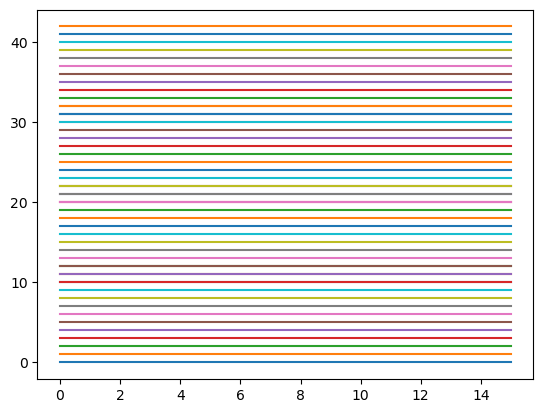

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
N_CLASSES = 13
N_LABELS = 4
labels = {label: 0 for label in range(N_CLASSES)}
labels['label'] = 1
labels['label']

batch_buff =pd.DataFrame()
train_class_ious = [[],[],[],[]]
k = 0
while (k <16):
    for i in range(N_LABELS):
        for j in range(N_CLASSES):
            train_class_ious[i].append(i*10 + j)
        train_class_ious[i].append(i)
    k += 1
ious  = pd.DataFrame()
for i in range(N_LABELS):
    buff = np.array(train_class_ious[i]).reshape(-1,N_CLASSES+1)
    buff_df = pd.DataFrame(buff)
    buff2 = np.mean(buff[:,:N_CLASSES], axis=0)
    batch_buff = pd.concat([batch_buff,buff_df])
for i in range(N_LABELS):
    buff = (batch_buff.loc[batch_buff[13]==i].drop(columns=[13]))
    plt.plot(buff)
plt.show()

In [11]:
for epoch in range(EP):
    model.train()
    epoch_loss = 0
    seg_losses = 0
    domain_losses = 0
    alpha = 0.0045
    train_class_ious = [[],[],[],[]]
    
    # label_dfs = {label: None for label in range(N_LABELS)}
    print(alpha)
    for source_images, source_masks in tqdm(source_dataloader,desc=f"Epoch: {epoch+1}"):
        for label in range(N_LABELS): 
            source_image, source_mask = apply_fisheye_distortion(source_images, source_masks, label)
            source_image = source_image.float().to(device)
            source_mask = source_mask.long().to(device)
            source_outputs = model(source_image)
            
            optimizer.zero_grad()
            target_loss, seg_loss, domain_loss = loss_fn(source_outputs, source_mask, label, alpha = alpha)
            epoch_loss += target_loss.item()
            seg_losses +=  seg_loss.item()
            domain_losses += domain_loss.item()
            target_loss.backward()
            optimizer.step()
            # miou측정
            source_outputs = model(source_image)
            source_outputs = torch.softmax(source_outputs[0], dim=1).cpu()
            source_outputs = torch.argmax(source_outputs, dim=1).numpy()
            
            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(source_masks.cpu()), np.array(source_outputs), class_id)
                train_class_ious[label].append(iou)
            
    for i in range(N_LABELS):
        buff = np.array(train_class_ious[i]).reshape(-1,N_CLASSES)
        buff = np.mean(buff, axis=0)
        print(f"\nLabel_{i}: IoU Scores Train")
        for class_id, iou in enumerate(buff):
            print(f'Class{class_id:02d}: {iou:.4f}', end=" ")
            if (class_id+1) % 7 == 0:
                print()   
    print()    
    print(f"Train seg Loss: {(seg_losses/(N_LABELS*len(source_dataloader)))}",f"Train dom Loss: {(domain_losses/(N_LABELS*len(source_dataloader)))}")
    print(f"Train Loss: {(epoch_loss/(N_LABELS*len(source_dataloader)))}")
    print(f"Train mIoU: {np.mean(train_class_ious)}" )
    ################################################################
    # 클래스별 IoU를 누적할 리스트 초기화
    val_class_ious = []
    fish_val_class_ious = []
    val_epoch_loss = 0
    val_seg_loss = 0
    val_domain_loss = 0
    # valid
    model.eval()
    with torch.no_grad():
        
        for target_images, target_masks in tqdm(val_target_dataloader):
            label = 2.5
            target_images, target_masks = apply_fisheye_distortion(target_images, target_masks, label)
            target_images = target_images.float().to(device)
            target_masks = target_masks.long().to(device)

            target_outputs = model(target_images)

            target_loss, target_seg_loss, target_domain_loss = loss_fn(target_outputs, target_masks, label, alpha = alpha)

            val_seg_loss +=  target_seg_loss.item()
            val_domain_loss += target_domain_loss.item()
            
            loss = target_loss

            val_epoch_loss += loss.item()

            # train 클래스별 IoU 계산
            target_outputs = torch.softmax(target_outputs[0], dim=1).cpu()
            target_outputs = torch.argmax(target_outputs, dim=1).numpy()

            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(target_masks.cpu()), np.array(target_outputs), class_id)
                fish_val_class_ious.append(iou)

    fish_val_class_ious = np.array(fish_val_class_ious).reshape(-1,N_CLASSES)
    fish_val_class_ious = np.mean(fish_val_class_ious, axis=0)
    print()
    print("--IoU Scores Fish val--")
    for class_id, iou in enumerate(fish_val_class_ious):
        print(f'Class{class_id}: {iou:.4f}', end=" ")
        if (class_id+1) % 7 == 0:
            print()

    # mIoU 계산
    fish_val_mIoU = np.mean(fish_val_class_ious)

    # 에폭마다 결과 출력 
    print(f"\nEpoch{epoch+1}")
    print(f"Valid_Seg Loss: {(val_seg_loss/len(val_target_dataloader))}",f"Valid_dom Loss: {(val_domain_loss/len(val_target_dataloader))}")
    print(f"Valid Loss: {(val_epoch_loss/len(val_target_dataloader))}")
    print(f"Valid mIoU: {fish_val_mIoU}" )
    print("___________________________________________________________________________________________\n")

print("Hyperparamerters")
print(f"LR = {LR} | EP = {EP}, BATCH_SIZE = {BATCH_SIZE}, N_CLASSES = {N_CLASSES}, init_alpha = {alpha}, N_LABELS = {N_LABELS}")

0.0045


Epoch: 1: 100%|██████████| 138/138 [07:05<00:00,  3.08s/it]



Label_0: IoU Scores Train
Class00: 0.1724 Class01: 0.1194 Class02: 0.0003 Class03: 0.0598 Class04: 0.0008 Class05: 0.0003 Class06: 0.0003 
Class07: 0.0001 Class08: 0.0130 Class09: 0.2252 Class10: 0.0003 Class11: 0.0001 Class12: 0.0046 
Label_1: IoU Scores Train
Class00: 0.1658 Class01: 0.1265 Class02: 0.0002 Class03: 0.0686 Class04: 0.0011 Class05: 0.0003 Class06: 0.0004 
Class07: 0.0002 Class08: 0.0141 Class09: 0.1610 Class10: 0.0003 Class11: 0.0001 Class12: 0.0056 
Label_2: IoU Scores Train
Class00: 0.1606 Class01: 0.1219 Class02: 0.0003 Class03: 0.0643 Class04: 0.0008 Class05: 0.0001 Class06: 0.0004 
Class07: 0.0003 Class08: 0.0149 Class09: 0.1457 Class10: 0.0003 Class11: 0.0001 Class12: 0.0054 
Label_3: IoU Scores Train
Class00: 0.1557 Class01: 0.1164 Class02: 0.0003 Class03: 0.0568 Class04: 0.0009 Class05: 0.0001 Class06: 0.0004 
Class07: 0.0003 Class08: 0.0124 Class09: 0.1333 Class10: 0.0003 Class11: 0.0001 Class12: 0.0043 
Train seg Loss: 2.2316132707224376 Train dom Loss: 1263

100%|██████████| 30/30 [00:11<00:00,  2.63it/s]



--IoU Scores Fish val--
Class0: 0.5326 Class1: 0.0000 Class2: 0.0000 Class3: 0.0524 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0000 Class8: 0.0000 Class9: 0.1778 Class10: 0.0000 Class11: 0.0000 Class12: 0.0000 
Epoch1
Valid_Seg Loss: 2.1393539985020955 Valid_dom Loss: 17.425287691752114
Valid Loss: 2.217767771085103
Valid mIoU: 0.05866969448404914
___________________________________________________________________________________________

0.0045


Epoch: 2: 100%|██████████| 138/138 [06:59<00:00,  3.04s/it]



Label_0: IoU Scores Train
Class00: 0.1603 Class01: 0.0085 Class02: 0.0000 Class03: 0.0317 Class04: 0.0000 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.0126 Class09: 0.3755 Class10: 0.0000 Class11: 0.0000 Class12: 0.0000 
Label_1: IoU Scores Train
Class00: 0.1620 Class01: 0.0151 Class02: 0.0000 Class03: 0.0313 Class04: 0.0000 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.0145 Class09: 0.3258 Class10: 0.0000 Class11: 0.0000 Class12: 0.0001 
Label_2: IoU Scores Train
Class00: 0.1604 Class01: 0.0144 Class02: 0.0000 Class03: 0.0189 Class04: 0.0000 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.0122 Class09: 0.2941 Class10: 0.0000 Class11: 0.0000 Class12: 0.0001 
Label_3: IoU Scores Train
Class00: 0.1559 Class01: 0.0130 Class02: 0.0000 Class03: 0.0128 Class04: 0.0000 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0001 Class08: 0.0078 Class09: 0.2567 Class10: 0.0000 Class11: 0.0000 Class12: 0.0002 
Train seg Loss: 1.8398766444213148 Train dom Loss: 54.7

100%|██████████| 30/30 [00:37<00:00,  1.26s/it]



--IoU Scores Fish val--
Class0: 0.6499 Class1: 0.0145 Class2: 0.0000 Class3: 0.0105 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0000 Class8: 0.0000 Class9: 0.6507 Class10: 0.0000 Class11: 0.0000 Class12: 0.0000 
Epoch2
Valid_Seg Loss: 1.3734010020891825 Valid_dom Loss: 173.02322692871093
Valid Loss: 2.1520054578781127
Valid mIoU: 0.10196505628630483
___________________________________________________________________________________________

0.0045


Epoch: 3: 100%|██████████| 138/138 [07:50<00:00,  3.41s/it]



Label_0: IoU Scores Train
Class00: 0.2053 Class01: 0.1934 Class02: 0.0000 Class03: 0.0308 Class04: 0.0000 Class05: 0.0000 Class06: 0.0001 
Class07: 0.0001 Class08: 0.0124 Class09: 0.5713 Class10: 0.0000 Class11: 0.0000 Class12: 0.0039 
Label_1: IoU Scores Train
Class00: 0.1956 Class01: 0.1539 Class02: 0.0000 Class03: 0.0294 Class04: 0.0001 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0002 Class08: 0.0196 Class09: 0.3559 Class10: 0.0000 Class11: 0.0000 Class12: 0.0022 
Label_2: IoU Scores Train
Class00: 0.1897 Class01: 0.1129 Class02: 0.0001 Class03: 0.0243 Class04: 0.0002 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0002 Class08: 0.0222 Class09: 0.3045 Class10: 0.0000 Class11: 0.0000 Class12: 0.0004 
Label_3: IoU Scores Train
Class00: 0.1843 Class01: 0.0893 Class02: 0.0001 Class03: 0.0181 Class04: 0.0000 Class05: 0.0000 Class06: 0.0001 
Class07: 0.0001 Class08: 0.0098 Class09: 0.2752 Class10: 0.0000 Class11: 0.0000 Class12: 0.0018 
Train seg Loss: 1.4768072582673335 Train dom Loss: 279.

100%|██████████| 30/30 [00:11<00:00,  2.51it/s]



--IoU Scores Fish val--
Class0: 0.7141 Class1: 0.2295 Class2: 0.0000 Class3: 0.0003 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0000 Class8: 0.0000 Class9: 0.5696 Class10: 0.0000 Class11: 0.0000 Class12: 0.0000 
Epoch3
Valid_Seg Loss: 1.2621179540952048 Valid_dom Loss: 2159.5450642903647
Valid Loss: 10.980070368448894
Valid mIoU: 0.11642886601807435
___________________________________________________________________________________________

0.0045


Epoch: 4: 100%|██████████| 138/138 [07:14<00:00,  3.15s/it]



Label_0: IoU Scores Train
Class00: 0.1986 Class01: 0.0905 Class02: 0.0009 Class03: 0.0368 Class04: 0.0001 Class05: 0.0002 Class06: 0.0001 
Class07: 0.0003 Class08: 0.0150 Class09: 0.6140 Class10: 0.0000 Class11: 0.0000 Class12: 0.0089 
Label_1: IoU Scores Train
Class00: 0.1971 Class01: 0.0716 Class02: 0.0006 Class03: 0.0557 Class04: 0.0004 Class05: 0.0001 Class06: 0.0000 
Class07: 0.0003 Class08: 0.0287 Class09: 0.3728 Class10: 0.0000 Class11: 0.0001 Class12: 0.0129 
Label_2: IoU Scores Train
Class00: 0.1920 Class01: 0.0503 Class02: 0.0011 Class03: 0.0541 Class04: 0.0011 Class05: 0.0003 Class06: 0.0000 
Class07: 0.0006 Class08: 0.0194 Class09: 0.3154 Class10: 0.0000 Class11: 0.0000 Class12: 0.0132 
Label_3: IoU Scores Train
Class00: 0.1870 Class01: 0.0432 Class02: 0.0005 Class03: 0.0436 Class04: 0.0004 Class05: 0.0001 Class06: 0.0001 
Class07: 0.0003 Class08: 0.0097 Class09: 0.2858 Class10: 0.0001 Class11: 0.0000 Class12: 0.0155 
Train seg Loss: 1.4533524539159692 Train dom Loss: 360.

100%|██████████| 30/30 [00:36<00:00,  1.23s/it]



--IoU Scores Fish val--
Class0: 0.6859 Class1: 0.0001 Class2: 0.0000 Class3: 0.0797 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0000 Class8: 0.0107 Class9: 0.5607 Class10: 0.0000 Class11: 0.0000 Class12: 0.0000 
Epoch4
Valid_Seg Loss: 1.0938311020533245 Valid_dom Loss: 67.34178937276205
Valid Loss: 1.396869146823883
Valid mIoU: 0.10285012620987641
___________________________________________________________________________________________

0.0045


Epoch: 5: 100%|██████████| 138/138 [07:55<00:00,  3.45s/it]



Label_0: IoU Scores Train
Class00: 0.2177 Class01: 0.0746 Class02: 0.0005 Class03: 0.1106 Class04: 0.0004 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.0153 Class09: 0.6485 Class10: 0.0000 Class11: 0.0000 Class12: 0.0080 
Label_1: IoU Scores Train
Class00: 0.2145 Class01: 0.0920 Class02: 0.0006 Class03: 0.1381 Class04: 0.0012 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.0184 Class09: 0.3720 Class10: 0.0000 Class11: 0.0000 Class12: 0.0095 
Label_2: IoU Scores Train
Class00: 0.2082 Class01: 0.0841 Class02: 0.0006 Class03: 0.1280 Class04: 0.0012 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.0134 Class09: 0.3170 Class10: 0.0000 Class11: 0.0000 Class12: 0.0105 
Label_3: IoU Scores Train
Class00: 0.2042 Class01: 0.0655 Class02: 0.0004 Class03: 0.1181 Class04: 0.0010 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.0098 Class09: 0.2878 Class10: 0.0000 Class11: 0.0000 Class12: 0.0082 
Train seg Loss: 1.3009388619574949 Train dom Loss: 139.

100%|██████████| 30/30 [00:40<00:00,  1.34s/it]



--IoU Scores Fish val--
Class0: 0.7489 Class1: 0.0000 Class2: 0.0000 Class3: 0.1882 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0000 Class8: 0.0000 Class9: 0.6009 Class10: 0.0000 Class11: 0.0000 Class12: 0.0001 
Epoch5
Valid_Seg Loss: 1.121365668376287 Valid_dom Loss: 216.39457295735676
Valid Loss: 2.0951411962509154
Valid mIoU: 0.11831736100947542
___________________________________________________________________________________________

0.0045


Epoch: 6: 100%|██████████| 138/138 [07:48<00:00,  3.39s/it]



Label_0: IoU Scores Train
Class00: 0.2665 Class01: 0.1273 Class02: 0.0009 Class03: 0.1740 Class04: 0.0017 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0004 Class08: 0.1992 Class09: 0.7009 Class10: 0.0006 Class11: 0.0001 Class12: 0.0139 
Label_1: IoU Scores Train
Class00: 0.2434 Class01: 0.1035 Class02: 0.0020 Class03: 0.1879 Class04: 0.0047 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.1713 Class09: 0.3951 Class10: 0.0004 Class11: 0.0000 Class12: 0.0144 
Label_2: IoU Scores Train
Class00: 0.2285 Class01: 0.0888 Class02: 0.0028 Class03: 0.1683 Class04: 0.0040 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.1561 Class09: 0.3347 Class10: 0.0001 Class11: 0.0002 Class12: 0.0176 
Label_3: IoU Scores Train
Class00: 0.2217 Class01: 0.0845 Class02: 0.0020 Class03: 0.1541 Class04: 0.0024 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.1437 Class09: 0.3049 Class10: 0.0004 Class11: 0.0000 Class12: 0.0185 
Train seg Loss: 1.1661280575005903 Train dom Loss: 146.

100%|██████████| 30/30 [00:35<00:00,  1.18s/it]



--IoU Scores Fish val--
Class0: 0.8598 Class1: 0.2187 Class2: 0.0000 Class3: 0.1966 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0000 Class8: 0.4585 Class9: 0.7416 Class10: 0.0000 Class11: 0.0000 Class12: 0.0146 
Epoch6
Valid_Seg Loss: 0.873579595486323 Valid_dom Loss: 55.41817824045817
Valid Loss: 1.1229613840579986
Valid mIoU: 0.19152416990803467
___________________________________________________________________________________________

0.0045


Epoch: 7: 100%|██████████| 138/138 [07:44<00:00,  3.37s/it]



Label_0: IoU Scores Train
Class00: 0.3381 Class01: 0.3633 Class02: 0.0014 Class03: 0.2016 Class04: 0.0075 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.4364 Class09: 0.7497 Class10: 0.0000 Class11: 0.0003 Class12: 0.0622 
Label_1: IoU Scores Train
Class00: 0.2703 Class01: 0.2907 Class02: 0.0028 Class03: 0.2154 Class04: 0.0082 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.3472 Class09: 0.4515 Class10: 0.0004 Class11: 0.0004 Class12: 0.0515 
Label_2: IoU Scores Train
Class00: 0.2458 Class01: 0.2617 Class02: 0.0044 Class03: 0.1975 Class04: 0.0109 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.3078 Class09: 0.3857 Class10: 0.0009 Class11: 0.0008 Class12: 0.0479 
Label_3: IoU Scores Train
Class00: 0.2377 Class01: 0.2366 Class02: 0.0044 Class03: 0.1850 Class04: 0.0108 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.2828 Class09: 0.3513 Class10: 0.0002 Class11: 0.0013 Class12: 0.0606 
Train seg Loss: 1.0607265830039978 Train dom Loss: 122.

100%|██████████| 30/30 [00:36<00:00,  1.21s/it]



--IoU Scores Fish val--
Class0: 0.8929 Class1: 0.4043 Class2: 0.0000 Class3: 0.2757 Class4: 0.0533 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0000 Class8: 0.4521 Class9: 0.8314 Class10: 0.0000 Class11: 0.0000 Class12: 0.0024 
Epoch7
Valid_Seg Loss: 1.0202822923660277 Valid_dom Loss: 408.813193766276
Valid Loss: 2.859941569964091
Valid mIoU: 0.22400389625433934
___________________________________________________________________________________________

0.0045


Epoch: 8: 100%|██████████| 138/138 [07:51<00:00,  3.41s/it]



Label_0: IoU Scores Train
Class00: 0.3818 Class01: 0.4564 Class02: 0.0036 Class03: 0.2257 Class04: 0.0099 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.4687 Class09: 0.7832 Class10: 0.0004 Class11: 0.0004 Class12: 0.0892 
Label_1: IoU Scores Train
Class00: 0.2880 Class01: 0.4231 Class02: 0.0055 Class03: 0.2573 Class04: 0.0075 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.3560 Class09: 0.4984 Class10: 0.0002 Class11: 0.0005 Class12: 0.0743 
Label_2: IoU Scores Train
Class00: 0.2570 Class01: 0.3890 Class02: 0.0056 Class03: 0.2410 Class04: 0.0079 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.3025 Class09: 0.4247 Class10: 0.0003 Class11: 0.0011 Class12: 0.0628 
Label_3: IoU Scores Train
Class00: 0.2423 Class01: 0.3520 Class02: 0.0067 Class03: 0.2274 Class04: 0.0127 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0000 Class08: 0.2706 Class09: 0.3844 Class10: 0.0002 Class11: 0.0008 Class12: 0.0749 
Train seg Loss: 0.968349265879479 Train dom Loss: 130.0

100%|██████████| 30/30 [00:29<00:00,  1.00it/s]



--IoU Scores Fish val--
Class0: 0.8760 Class1: 0.3314 Class2: 0.0001 Class3: 0.1992 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0011 Class8: 0.3836 Class9: 0.6978 Class10: 0.0000 Class11: 0.0000 Class12: 0.0000 
Epoch8
Valid_Seg Loss: 0.8672616759936015 Valid_dom Loss: 245.90127665201823
Valid Loss: 1.9738173961639405
Valid mIoU: 0.19147617136054135
___________________________________________________________________________________________

0.0045


Epoch: 9: 100%|██████████| 138/138 [06:57<00:00,  3.02s/it]



Label_0: IoU Scores Train
Class00: 0.3733 Class01: 0.2608 Class02: 0.0011 Class03: 0.1935 Class04: 0.0016 Class05: 0.0002 Class06: 0.0000 
Class07: 0.0016 Class08: 0.4293 Class09: 0.6195 Class10: 0.0000 Class11: 0.0000 Class12: 0.0111 
Label_1: IoU Scores Train
Class00: 0.2859 Class01: 0.3128 Class02: 0.0009 Class03: 0.2207 Class04: 0.0013 Class05: 0.0003 Class06: 0.0001 
Class07: 0.0002 Class08: 0.3398 Class09: 0.4586 Class10: 0.0000 Class11: 0.0000 Class12: 0.0104 
Label_2: IoU Scores Train
Class00: 0.2575 Class01: 0.2846 Class02: 0.0012 Class03: 0.2035 Class04: 0.0008 Class05: 0.0001 Class06: 0.0000 
Class07: 0.0001 Class08: 0.2989 Class09: 0.3907 Class10: 0.0000 Class11: 0.0000 Class12: 0.0135 
Label_3: IoU Scores Train
Class00: 0.2407 Class01: 0.2601 Class02: 0.0006 Class03: 0.1900 Class04: 0.0008 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0004 Class08: 0.2727 Class09: 0.3516 Class10: 0.0000 Class11: 0.0000 Class12: 0.0137 
Train seg Loss: 1.1029427227550659 Train dom Loss: 307.

100%|██████████| 30/30 [00:11<00:00,  2.70it/s]



--IoU Scores Fish val--
Class0: 0.8679 Class1: 0.1180 Class2: 0.0001 Class3: 0.2238 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0012 Class8: 0.3446 Class9: 0.7978 Class10: 0.0000 Class11: 0.0000 Class12: 0.0000 
Epoch9
Valid_Seg Loss: 0.8211142877737682 Valid_dom Loss: 24.116553433736165
Valid Loss: 0.9296387652556102
Valid mIoU: 0.18102956565671338
___________________________________________________________________________________________

0.0045


Epoch: 10: 100%|██████████| 138/138 [07:09<00:00,  3.11s/it]



Label_0: IoU Scores Train
Class00: 0.5021 Class01: 0.5160 Class02: 0.0000 Class03: 0.2797 Class04: 0.0001 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0158 Class08: 0.4690 Class09: 0.8270 Class10: 0.0000 Class11: 0.0000 Class12: 0.0704 
Label_1: IoU Scores Train
Class00: 0.2995 Class01: 0.4204 Class02: 0.0000 Class03: 0.2396 Class04: 0.0001 Class05: 0.0001 Class06: 0.0000 
Class07: 0.0123 Class08: 0.3522 Class09: 0.5092 Class10: 0.0000 Class11: 0.0000 Class12: 0.0953 
Label_2: IoU Scores Train
Class00: 0.2632 Class01: 0.3801 Class02: 0.0000 Class03: 0.2265 Class04: 0.0001 Class05: 0.0001 Class06: 0.0000 
Class07: 0.0122 Class08: 0.3087 Class09: 0.4335 Class10: 0.0000 Class11: 0.0000 Class12: 0.0980 
Label_3: IoU Scores Train
Class00: 0.2453 Class01: 0.3553 Class02: 0.0000 Class03: 0.2149 Class04: 0.0002 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0133 Class08: 0.2774 Class09: 0.3856 Class10: 0.0000 Class11: 0.0000 Class12: 0.0978 
Train seg Loss: 0.8599952677453774 Train dom Loss: 54.7

100%|██████████| 30/30 [00:42<00:00,  1.42s/it]



--IoU Scores Fish val--
Class0: 0.9422 Class1: 0.5381 Class2: 0.0000 Class3: 0.1098 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0817 Class8: 0.4180 Class9: 0.8110 Class10: 0.0000 Class11: 0.0000 Class12: 0.1634 
Epoch10
Valid_Seg Loss: 0.6309342364470164 Valid_dom Loss: 365.4535756429037
Valid Loss: 2.275475279490153
Valid mIoU: 0.23570380927257473
___________________________________________________________________________________________

0.0045


Epoch: 11: 100%|██████████| 138/138 [07:39<00:00,  3.33s/it]



Label_0: IoU Scores Train
Class00: 0.5781 Class01: 0.5419 Class02: 0.0000 Class03: 0.3555 Class04: 0.0001 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0527 Class08: 0.4993 Class09: 0.8227 Class10: 0.0001 Class11: 0.0000 Class12: 0.1502 
Label_1: IoU Scores Train
Class00: 0.2983 Class01: 0.4539 Class02: 0.0000 Class03: 0.3038 Class04: 0.0004 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0186 Class08: 0.3796 Class09: 0.5382 Class10: 0.0000 Class11: 0.0000 Class12: 0.1837 
Label_2: IoU Scores Train
Class00: 0.2611 Class01: 0.4114 Class02: 0.0001 Class03: 0.2689 Class04: 0.0005 Class05: 0.0000 Class06: 0.0001 
Class07: 0.0151 Class08: 0.3282 Class09: 0.4488 Class10: 0.0000 Class11: 0.0000 Class12: 0.1797 
Label_3: IoU Scores Train
Class00: 0.2434 Class01: 0.3860 Class02: 0.0001 Class03: 0.2525 Class04: 0.0006 Class05: 0.0001 Class06: 0.0001 
Class07: 0.0144 Class08: 0.2990 Class09: 0.4050 Class10: 0.0000 Class11: 0.0000 Class12: 0.1764 
Train seg Loss: 0.8321706246638644 Train dom Loss: 142.

100%|██████████| 30/30 [00:38<00:00,  1.29s/it]



--IoU Scores Fish val--
Class0: 0.8441 Class1: 0.4363 Class2: 0.0000 Class3: 0.2890 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0000 Class8: 0.3761 Class9: 0.7819 Class10: 0.0000 Class11: 0.0000 Class12: 0.0074 
Epoch11
Valid_Seg Loss: 1.4893698811531066 Valid_dom Loss: 2771.8489664713543
Valid Loss: 13.96268965403239
Valid mIoU: 0.2103774814185431
___________________________________________________________________________________________

0.0045


Epoch: 12: 100%|██████████| 138/138 [07:37<00:00,  3.32s/it]



Label_0: IoU Scores Train
Class00: 0.3348 Class01: 0.3122 Class02: 0.0023 Class03: 0.1652 Class04: 0.0015 Class05: 0.0005 Class06: 0.0000 
Class07: 0.0034 Class08: 0.4212 Class09: 0.6155 Class10: 0.0000 Class11: 0.0000 Class12: 0.0277 
Label_1: IoU Scores Train
Class00: 0.2606 Class01: 0.3207 Class02: 0.0038 Class03: 0.1837 Class04: 0.0019 Class05: 0.0001 Class06: 0.0001 
Class07: 0.0010 Class08: 0.3259 Class09: 0.4388 Class10: 0.0000 Class11: 0.0000 Class12: 0.0228 
Label_2: IoU Scores Train
Class00: 0.2422 Class01: 0.3061 Class02: 0.0016 Class03: 0.1742 Class04: 0.0020 Class05: 0.0005 Class06: 0.0001 
Class07: 0.0010 Class08: 0.2898 Class09: 0.3760 Class10: 0.0000 Class11: 0.0001 Class12: 0.0173 
Label_3: IoU Scores Train
Class00: 0.2302 Class01: 0.2731 Class02: 0.0015 Class03: 0.1587 Class04: 0.0009 Class05: 0.0002 Class06: 0.0001 
Class07: 0.0008 Class08: 0.2692 Class09: 0.3376 Class10: 0.0000 Class11: 0.0000 Class12: 0.0189 
Train seg Loss: 1.6177089359017387 Train dom Loss: 1197

100%|██████████| 30/30 [00:38<00:00,  1.28s/it]



--IoU Scores Fish val--
Class0: 0.8548 Class1: 0.3296 Class2: 0.0109 Class3: 0.1577 Class4: 0.0342 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0002 Class8: 0.4491 Class9: 0.4615 Class10: 0.0000 Class11: 0.0000 Class12: 0.0037 
Epoch12
Valid_Seg Loss: 1.2480236570040384 Valid_dom Loss: 4.484755452473959
Valid Loss: 1.2682050585746765
Valid mIoU: 0.17705278012570866
___________________________________________________________________________________________

0.0045


Epoch: 13: 100%|██████████| 138/138 [07:35<00:00,  3.30s/it]



Label_0: IoU Scores Train
Class00: 0.4250 Class01: 0.4372 Class02: 0.0010 Class03: 0.2418 Class04: 0.0017 Class05: 0.0002 Class06: 0.0001 
Class07: 0.0055 Class08: 0.4924 Class09: 0.7348 Class10: 0.0001 Class11: 0.0000 Class12: 0.0220 
Label_1: IoU Scores Train
Class00: 0.2853 Class01: 0.3877 Class02: 0.0010 Class03: 0.2268 Class04: 0.0039 Class05: 0.0004 Class06: 0.0001 
Class07: 0.0026 Class08: 0.3681 Class09: 0.4904 Class10: 0.0001 Class11: 0.0000 Class12: 0.0215 
Label_2: IoU Scores Train
Class00: 0.2560 Class01: 0.3513 Class02: 0.0016 Class03: 0.2006 Class04: 0.0025 Class05: 0.0006 Class06: 0.0002 
Class07: 0.0028 Class08: 0.3281 Class09: 0.4161 Class10: 0.0003 Class11: 0.0000 Class12: 0.0239 
Label_3: IoU Scores Train
Class00: 0.2400 Class01: 0.3237 Class02: 0.0009 Class03: 0.1840 Class04: 0.0023 Class05: 0.0007 Class06: 0.0002 
Class07: 0.0025 Class08: 0.3007 Class09: 0.3698 Class10: 0.0004 Class11: 0.0000 Class12: 0.0238 
Train seg Loss: 1.2161759341108627 Train dom Loss: 929.

100%|██████████| 30/30 [00:41<00:00,  1.39s/it]



--IoU Scores Fish val--
Class0: 0.9237 Class1: 0.5682 Class2: 0.0000 Class3: 0.2930 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0004 Class8: 0.3985 Class9: 0.8310 Class10: 0.0000 Class11: 0.0000 Class12: 0.0157 
Epoch13
Valid_Seg Loss: 0.8274934689203898 Valid_dom Loss: 764.5214487711588
Valid Loss: 4.267839829126994
Valid mIoU: 0.23312143863751872
___________________________________________________________________________________________

0.0045


Epoch: 14: 100%|██████████| 138/138 [07:38<00:00,  3.32s/it]



Label_0: IoU Scores Train
Class00: 0.5302 Class01: 0.4953 Class02: 0.0021 Class03: 0.3242 Class04: 0.0031 Class05: 0.0006 Class06: 0.0001 
Class07: 0.0260 Class08: 0.5327 Class09: 0.8149 Class10: 0.0000 Class11: 0.0000 Class12: 0.0220 
Label_1: IoU Scores Train
Class00: 0.3036 Class01: 0.4331 Class02: 0.0012 Class03: 0.2768 Class04: 0.0019 Class05: 0.0003 Class06: 0.0001 
Class07: 0.0095 Class08: 0.3932 Class09: 0.5240 Class10: 0.0000 Class11: 0.0000 Class12: 0.0223 
Label_2: IoU Scores Train
Class00: 0.2621 Class01: 0.3921 Class02: 0.0009 Class03: 0.2497 Class04: 0.0020 Class05: 0.0004 Class06: 0.0001 
Class07: 0.0071 Class08: 0.3410 Class09: 0.4436 Class10: 0.0000 Class11: 0.0000 Class12: 0.0193 
Label_3: IoU Scores Train
Class00: 0.2453 Class01: 0.3624 Class02: 0.0007 Class03: 0.2322 Class04: 0.0012 Class05: 0.0004 Class06: 0.0001 
Class07: 0.0070 Class08: 0.3124 Class09: 0.3990 Class10: 0.0000 Class11: 0.0000 Class12: 0.0177 
Train seg Loss: 1.0593272038344024 Train dom Loss: 177.

100%|██████████| 30/30 [00:39<00:00,  1.33s/it]



--IoU Scores Fish val--
Class0: 0.9401 Class1: 0.4940 Class2: 0.0000 Class3: 0.2995 Class4: 0.0000 Class5: 0.0000 Class6: 0.0016 
Class7: 0.0197 Class8: 0.5040 Class9: 0.6814 Class10: 0.0000 Class11: 0.0000 Class12: 0.0174 
Epoch14
Valid_Seg Loss: 0.7196624120076497 Valid_dom Loss: 51.71913355191548
Valid Loss: 0.9523985048135122
Valid mIoU: 0.22751483092961167
___________________________________________________________________________________________

0.0045


Epoch: 15: 100%|██████████| 138/138 [07:36<00:00,  3.31s/it]



Label_0: IoU Scores Train
Class00: 0.6141 Class01: 0.5443 Class02: 0.0014 Class03: 0.3662 Class04: 0.0024 Class05: 0.0002 Class06: 0.0002 
Class07: 0.0743 Class08: 0.5434 Class09: 0.8406 Class10: 0.0000 Class11: 0.0000 Class12: 0.0522 
Label_1: IoU Scores Train
Class00: 0.3083 Class01: 0.4648 Class02: 0.0002 Class03: 0.3048 Class04: 0.0008 Class05: 0.0003 Class06: 0.0003 
Class07: 0.0239 Class08: 0.4067 Class09: 0.5384 Class10: 0.0000 Class11: 0.0000 Class12: 0.0542 
Label_2: IoU Scores Train
Class00: 0.2641 Class01: 0.4109 Class02: 0.0005 Class03: 0.2744 Class04: 0.0019 Class05: 0.0003 Class06: 0.0002 
Class07: 0.0171 Class08: 0.3540 Class09: 0.4563 Class10: 0.0000 Class11: 0.0000 Class12: 0.0504 
Label_3: IoU Scores Train
Class00: 0.2448 Class01: 0.3776 Class02: 0.0004 Class03: 0.2557 Class04: 0.0010 Class05: 0.0003 Class06: 0.0002 
Class07: 0.0149 Class08: 0.3232 Class09: 0.4087 Class10: 0.0000 Class11: 0.0000 Class12: 0.0462 
Train seg Loss: 0.8763506045915942 Train dom Loss: 140.

100%|██████████| 30/30 [00:42<00:00,  1.43s/it]



--IoU Scores Fish val--
Class0: 0.9273 Class1: 0.5747 Class2: 0.0000 Class3: 0.3117 Class4: 0.0002 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0392 Class8: 0.5003 Class9: 0.7603 Class10: 0.0000 Class11: 0.0000 Class12: 0.0607 
Epoch15
Valid_Seg Loss: 0.772592905163765 Valid_dom Loss: 48.862992159525554
Valid Loss: 0.9924763639767965
Valid mIoU: 0.2441884354190647
___________________________________________________________________________________________

0.0045


Epoch: 16: 100%|██████████| 138/138 [07:14<00:00,  3.15s/it]



Label_0: IoU Scores Train
Class00: 0.6861 Class01: 0.5742 Class02: 0.0006 Class03: 0.3932 Class04: 0.0006 Class05: 0.0003 Class06: 0.0005 
Class07: 0.0757 Class08: 0.5610 Class09: 0.8339 Class10: 0.0000 Class11: 0.0000 Class12: 0.0875 
Label_1: IoU Scores Train
Class00: 0.3113 Class01: 0.4792 Class02: 0.0000 Class03: 0.3164 Class04: 0.0005 Class05: 0.0003 Class06: 0.0004 
Class07: 0.0289 Class08: 0.4043 Class09: 0.5384 Class10: 0.0000 Class11: 0.0000 Class12: 0.0881 
Label_2: IoU Scores Train
Class00: 0.2660 Class01: 0.4270 Class02: 0.0001 Class03: 0.2827 Class04: 0.0004 Class05: 0.0004 Class06: 0.0002 
Class07: 0.0226 Class08: 0.3506 Class09: 0.4584 Class10: 0.0000 Class11: 0.0000 Class12: 0.0829 
Label_3: IoU Scores Train
Class00: 0.2456 Class01: 0.3941 Class02: 0.0002 Class03: 0.2609 Class04: 0.0004 Class05: 0.0002 Class06: 0.0003 
Class07: 0.0201 Class08: 0.3200 Class09: 0.4085 Class10: 0.0000 Class11: 0.0000 Class12: 0.0790 
Train seg Loss: 0.8727850527435109 Train dom Loss: 147.

100%|██████████| 30/30 [00:40<00:00,  1.34s/it]



--IoU Scores Fish val--
Class0: 0.9636 Class1: 0.6399 Class2: 0.0000 Class3: 0.2885 Class4: 0.0000 Class5: 0.0009 Class6: 0.0000 
Class7: 0.0411 Class8: 0.5542 Class9: 0.8033 Class10: 0.0000 Class11: 0.0000 Class12: 0.1831 
Epoch16
Valid_Seg Loss: 0.6898420015970866 Valid_dom Loss: 258.3565495808919
Valid Loss: 1.852446436882019
Valid mIoU: 0.2672827320766974
___________________________________________________________________________________________

0.0045


Epoch: 17: 100%|██████████| 138/138 [07:43<00:00,  3.36s/it]



Label_0: IoU Scores Train
Class00: 0.7512 Class01: 0.6061 Class02: 0.0001 Class03: 0.4325 Class04: 0.0001 Class05: 0.0006 Class06: 0.0005 
Class07: 0.0807 Class08: 0.5730 Class09: 0.8555 Class10: 0.0000 Class11: 0.0000 Class12: 0.1214 
Label_1: IoU Scores Train
Class00: 0.3122 Class01: 0.4900 Class02: 0.0000 Class03: 0.3286 Class04: 0.0000 Class05: 0.0005 Class06: 0.0005 
Class07: 0.0328 Class08: 0.4061 Class09: 0.5427 Class10: 0.0000 Class11: 0.0000 Class12: 0.1271 
Label_2: IoU Scores Train
Class00: 0.2663 Class01: 0.4364 Class02: 0.0000 Class03: 0.2855 Class04: 0.0000 Class05: 0.0005 Class06: 0.0007 
Class07: 0.0248 Class08: 0.3532 Class09: 0.4576 Class10: 0.0000 Class11: 0.0000 Class12: 0.1229 
Label_3: IoU Scores Train
Class00: 0.2456 Class01: 0.4021 Class02: 0.0000 Class03: 0.2641 Class04: 0.0000 Class05: 0.0003 Class06: 0.0005 
Class07: 0.0222 Class08: 0.3251 Class09: 0.4109 Class10: 0.0000 Class11: 0.0000 Class12: 0.1173 
Train seg Loss: 0.7858597395428712 Train dom Loss: 120.

100%|██████████| 30/30 [00:40<00:00,  1.35s/it]



--IoU Scores Fish val--
Class0: 0.9544 Class1: 0.6022 Class2: 0.0000 Class3: 0.3362 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0417 Class8: 0.4382 Class9: 0.6717 Class10: 0.0000 Class11: 0.0000 Class12: 0.1243 
Epoch17
Valid_Seg Loss: 0.7752468585968018 Valid_dom Loss: 24.799029382069907
Valid Loss: 0.8868424812952678
Valid mIoU: 0.24374352423218243
___________________________________________________________________________________________

0.0045


Epoch: 18: 100%|██████████| 138/138 [07:42<00:00,  3.35s/it]



Label_0: IoU Scores Train
Class00: 0.7840 Class01: 0.6250 Class02: 0.0000 Class03: 0.4561 Class04: 0.0000 Class05: 0.0006 Class06: 0.0032 
Class07: 0.0827 Class08: 0.5767 Class09: 0.8651 Class10: 0.0000 Class11: 0.0000 Class12: 0.1903 
Label_1: IoU Scores Train
Class00: 0.3146 Class01: 0.5010 Class02: 0.0000 Class03: 0.3361 Class04: 0.0000 Class05: 0.0002 Class06: 0.0015 
Class07: 0.0309 Class08: 0.4051 Class09: 0.5472 Class10: 0.0000 Class11: 0.0000 Class12: 0.1721 
Label_2: IoU Scores Train
Class00: 0.2678 Class01: 0.4501 Class02: 0.0000 Class03: 0.2993 Class04: 0.0000 Class05: 0.0003 Class06: 0.0017 
Class07: 0.0262 Class08: 0.3512 Class09: 0.4613 Class10: 0.0000 Class11: 0.0000 Class12: 0.1635 
Label_3: IoU Scores Train
Class00: 0.2463 Class01: 0.4153 Class02: 0.0000 Class03: 0.2783 Class04: 0.0000 Class05: 0.0006 Class06: 0.0012 
Class07: 0.0247 Class08: 0.3209 Class09: 0.4154 Class10: 0.0000 Class11: 0.0000 Class12: 0.1565 
Train seg Loss: 0.7353583825347216 Train dom Loss: 107.

100%|██████████| 30/30 [00:37<00:00,  1.25s/it]



--IoU Scores Fish val--
Class0: 0.9746 Class1: 0.7021 Class2: 0.0000 Class3: 0.4274 Class4: 0.0000 Class5: 0.0000 Class6: 0.0010 
Class7: 0.0197 Class8: 0.5793 Class9: 0.8781 Class10: 0.0000 Class11: 0.0000 Class12: 0.2989 
Epoch18
Valid_Seg Loss: 0.5124563038349151 Valid_dom Loss: 50.99209861755371
Valid Loss: 0.7419207334518433
Valid mIoU: 0.29854987366896607
___________________________________________________________________________________________

0.0045


Epoch: 19: 100%|██████████| 138/138 [07:46<00:00,  3.38s/it]



Label_0: IoU Scores Train
Class00: 0.8046 Class01: 0.6494 Class02: 0.0004 Class03: 0.4885 Class04: 0.0027 Class05: 0.0005 Class06: 0.0085 
Class07: 0.0942 Class08: 0.5936 Class09: 0.8752 Class10: 0.0000 Class11: 0.0000 Class12: 0.2610 
Label_1: IoU Scores Train
Class00: 0.3158 Class01: 0.5153 Class02: 0.0004 Class03: 0.3660 Class04: 0.0034 Class05: 0.0003 Class06: 0.0041 
Class07: 0.0373 Class08: 0.4137 Class09: 0.5558 Class10: 0.0000 Class11: 0.0000 Class12: 0.2415 
Label_2: IoU Scores Train
Class00: 0.2686 Class01: 0.4595 Class02: 0.0001 Class03: 0.3232 Class04: 0.0017 Class05: 0.0003 Class06: 0.0035 
Class07: 0.0307 Class08: 0.3594 Class09: 0.4711 Class10: 0.0000 Class11: 0.0001 Class12: 0.2298 
Label_3: IoU Scores Train
Class00: 0.2466 Class01: 0.4216 Class02: 0.0003 Class03: 0.2957 Class04: 0.0017 Class05: 0.0004 Class06: 0.0023 
Class07: 0.0295 Class08: 0.3291 Class09: 0.4215 Class10: 0.0000 Class11: 0.0000 Class12: 0.2170 
Train seg Loss: 0.679109843906717 Train dom Loss: 104.8

100%|██████████| 30/30 [00:41<00:00,  1.37s/it]



--IoU Scores Fish val--
Class0: 0.9572 Class1: 0.0065 Class2: 0.0001 Class3: 0.1643 Class4: 0.0000 Class5: 0.0018 Class6: 0.0002 
Class7: 0.0487 Class8: 0.5013 Class9: 0.0450 Class10: 0.0000 Class11: 0.0000 Class12: 0.0383 
Epoch19
Valid_Seg Loss: 1.250840131441752 Valid_dom Loss: 177.01876373291014
Valid Loss: 2.0474245309829713
Valid mIoU: 0.1356480629152214
___________________________________________________________________________________________

0.0045


Epoch: 20: 100%|██████████| 138/138 [07:41<00:00,  3.34s/it]



Label_0: IoU Scores Train
Class00: 0.6902 Class01: 0.5764 Class02: 0.0002 Class03: 0.4107 Class04: 0.0003 Class05: 0.0001 Class06: 0.0002 
Class07: 0.0557 Class08: 0.5586 Class09: 0.8473 Class10: 0.0000 Class11: 0.0000 Class12: 0.1565 
Label_1: IoU Scores Train
Class00: 0.3073 Class01: 0.4818 Class02: 0.0001 Class03: 0.3350 Class04: 0.0002 Class05: 0.0001 Class06: 0.0006 
Class07: 0.0187 Class08: 0.4079 Class09: 0.5452 Class10: 0.0000 Class11: 0.0000 Class12: 0.1787 
Label_2: IoU Scores Train
Class00: 0.2644 Class01: 0.4306 Class02: 0.0001 Class03: 0.2987 Class04: 0.0002 Class05: 0.0001 Class06: 0.0002 
Class07: 0.0132 Class08: 0.3547 Class09: 0.4624 Class10: 0.0000 Class11: 0.0000 Class12: 0.1740 
Label_3: IoU Scores Train
Class00: 0.2459 Class01: 0.3972 Class02: 0.0000 Class03: 0.2739 Class04: 0.0002 Class05: 0.0001 Class06: 0.0001 
Class07: 0.0114 Class08: 0.3241 Class09: 0.4144 Class10: 0.0000 Class11: 0.0000 Class12: 0.1676 
Train seg Loss: 0.8020437381405762 Train dom Loss: 105.

100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


--IoU Scores Fish val--
Class0: 0.9725 Class1: 0.6830 Class2: 0.0000 Class3: 0.3405 Class4: 0.0000 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0061 Class8: 0.5929 Class9: 0.8356 Class10: 0.0000 Class11: 0.0000 Class12: 0.2399 
Epoch20
Valid_Seg Loss: 0.552794149518013 Valid_dom Loss: 40.83839912414551
Valid Loss: 0.7365669389565785
Valid mIoU: 0.28234961327560054
___________________________________________________________________________________________

Hyperparamerters
LR = 0.001 | EP = 20, BATCH_SIZE = 16, N_CLASSES = 13, init_alpha = 0.0045, N_LABELS = 4


In [12]:
torch.save(model.state_dict(), './data/resnet34_1109_1.pth')
